In [40]:
from getopt import getopt
import cloudpickle
import pickle
import sys
import os
import numpy as np
import pandas as pd
# import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
from time import time, sleep
from datetime import timedelta

In [2]:
def resample(all_ids, param, size, bound=0.1):
    # resampling raters and topics such that effects sum to 0.

    s = inferred_glmm["summary_stat"][inferred_glmm["summary_stat"]["param"]==param].copy(deep=True)

    if param == "za":
        s[["a", "b"]] = s["param_num"].str.split(", ", expand=True)
        s["param_num"] = (s["a"].astype(int)*50 + s["b"].astype(int)).astype(str)

    mean_sum = 9999
    while mean_sum < -bound or mean_sum > bound:
        ids = np.random.choice(all_ids, size=size, replace=True)
        mean_sum = sum([s[(s["param_num"]==str(i))]["mean"].item() for i in ids])

    return ids

In [3]:
def simulate_scores(model, p_diff=0.08, n_raters=40, scores_per_r=40, trials_per_sim=1_000, seed=42):

    # Setting numpy seed
    np.random.seed(seed)

    # Creating df schema
    ps_data = pd.DataFrame(columns=["trial_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", 
                                    "cordel_id", "topic_id", "rater_id"], dtype=np.int16)

    for trial_id in range(trials_per_sim):

        # data template
        sim_data = pd.DataFrame(columns=["trial_id", "cordel_id", "topic_id", "rater_id"])  

        # Raters in this simulation
        raters = resample(data["rater_id"].unique(), param="zr", size=n_raters, bound=1)

        # Topics in this simulation (topic_cordel_ids index values)
        sim_topics_0 = resample(range(len(topic_cordel_ids)), param="za", size=50, bound=1)
        sim_topics_1 = resample(range(len(topic_cordel_ids)), param="za", size=50, bound=1)
        sim_topics = np.concatenate((sim_topics_0, sim_topics_1))

        # Current number of scores for each topic
        counts = np.zeros(100)

        for sim_rater_id, rater in enumerate(raters):
        #     Simulate scores for every rater and topic
            rated_topics = np.array(range(100))
            rated_topics_idx = sim_topics[rated_topics]

        #     Append topics to simulation
            d=topic_cordel_ids.loc[rated_topics_idx, ["topic_id", "cordel_id"]]
            d["sim_rater_id"]=sim_rater_id
            d["sim_topic_id"]=rated_topics
            d["rater_id"]=rater

            sim_data = pd.concat([sim_data, d], axis="rows", ignore_index=True)

    #     Adding one topic/rater interaction into df
        sim_data["trial_id"] = trial_id
        sim_data.loc[sim_data["sim_topic_id"].isin(range(0,50)),["sim_cordel_id"]] = 0
        sim_data.loc[sim_data["sim_topic_id"].isin(range(50,100)),["sim_cordel_id"]] = 1
    #     sim_data = pd.merge(sim_data, topic_counts[["cordel_id", "topic_id", "sim_cordel_id"]]
    #                         ,on=["cordel_id", "topic_id"], how="left")
        sim_data=sim_data.astype(np.int16)

    #     Appending interaction to ds.
        ps_data = pd.concat([ps_data, sim_data], ignore_index=True)

#         print(f"Completed simulating topic/rater interactions in {time() - startt:.2f}s")

#     Simulating Scores
    pymc_model = model["model"]
    trace = model["trace"].copy()

    # Calculating proposed logodds means
    # model1 = model0 + p
    # https://www.wolframalpha.com/input?i=solve+for+x+and+y%2C+x%2By%3Dc%2C+1%2F%281%2Be%5E-x%29-1%2F%281%2Be%5E-y%29%3Dp
    mean_model_logodds = model["summary_stat"][model["summary_stat"]["param"]=="mu"]["mean"].mean()
    c = 2*mean_model_logodds
    C = np.exp(-c)
    det = p_diff**2-2*C*(p_diff**2-2)+(C**2)*(p_diff**2)
    quad = (-p_diff*(C+1)+det**0.5)/(2*(p_diff+1))
    proposed_model1_mean = -np.log(quad)
    proposed_model0_mean = c-proposed_model1_mean

    # Setting trace of cordel 0 and cordel 1 to proposed values
    trace.posterior["mu"].loc[dict(mu_dim_0=0)] = proposed_model0_mean
    trace.posterior["mu"].loc[dict(mu_dim_0=1)] = proposed_model1_mean

    sim_scores = pd.DataFrame(columns=["trial_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", "cordel_id", "topic_id", "rater_id", "intrusion", ]
                       ,dtype=np.int16)

# TODO: add chain options
    for trial_id in range(trials_per_sim):
        # Setting data containing rater/topic interaction
        sim_data = ps_data[ps_data["trial_id"]==trial_id]
        sim_rater_array = np.array(sim_data["rater_id"], dtype=int)
        topic_array = np.array([sim_data["cordel_id"], sim_data["topic_id"]], dtype=int)
        cordel_array = np.array(sim_data["sim_cordel_id"], dtype=int)

        # Running simulation
        with pymc_model:
            pm.set_data({
                "raters":sim_rater_array, 
                "topics":topic_array, 
                "cordels":cordel_array})
            postrr_sim=pm.sample_posterior_predictive(trace.posterior.sel(
                {"chain":[0], "draw":[np.random.randint(2**20) if trials_per_sim==1 else trial_id]})
                ,predictions=True, progressbar=False, random_seed=np.random.randint(2**20))

        # Adding results to sim_scores
        s = (postrr_sim.predictions.to_dataframe().reset_index()
              .rename(columns={"s":"intrusion"}))
        trial_sim_scores = pd.concat([sim_data.reset_index(drop=True)
                                     ,s["intrusion"]], axis="columns").astype(np.int16)
# Add algorithm here
        sim_scores = pd.concat([sim_scores, trial_sim_scores], axis="index", ignore_index=True)
        

        
    return sim_scores

In [4]:
# Reading in data
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 

d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
obs_n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

# Adding cordel id to topic_ids dataframe
topic_cordel_ids = pd.merge(topic_ids, cordel_ids, on=["corpus", "model"], how="left")

# Reading model
with open("bayesian_model/glmm.pickle", "rb") as f:
    inferred_glmm = cloudpickle.load(f)

In [5]:

all_scores = simulate_scores(
    inferred_glmm,
#     p_diff=p_diff,
#     n_raters=n_raters,
#     scores_per_r=scores_per_r,
    trials_per_sim=1,
#     seed=run_seed
)

Sampling: [s]
INFO:pymc:Sampling: [s]


In [7]:
def postrr_var(n_success, total):
    a = n_success+1
    b = total-n_success+1
    return a*b/((a+b+1)*(a+b)**2)

In [64]:
max_raters=40
scores_per_r=40
n_available_scores = 1300
scores = all_scores[:0]

for sim_rater_id in range(max_raters):
    # Checking if all scores have been allocated
    if n_available_scores <= 0:
        break

    # Calculating variance for each topic's posterior distribution
    s = (scores.groupby("sim_topic_id").agg({"intrusion":"sum"})
         .rename(columns={"intrusion":"sum"}).reset_index())
    c = (scores.groupby("sim_topic_id").agg({"intrusion":"count"})
         .rename(columns={"intrusion":"count"}).reset_index())
    topic_var = pd.merge(s, c, on="sim_topic_id")
    
    # Create df with zeros if no data exists
    if len(topic_var) < 100:
        missing_topic_ids = [i for i in range(100) if i not in np.array(topic_var["sim_topic_id"])]
        missings = pd.DataFrame({"sim_topic_id":missing_topic_ids
                                  ,"sum":[0]*len(missing_topic_ids)
                                  ,"count":[0]*len(missing_topic_ids)})
        topic_var = pd.concat([topic_var, missings])

    # Calculating posterior variances
    topic_var["variance"] = postrr_var(topic_var["sum"], topic_var["count"])

    # Finding minimum priority value of second column
    # Finding minimum priority value of second column
    cutoff = topic_var["variance"].max()/3**0.5

    # Allocating topics
    allocated_topics = (topic_var[topic_var["variance"]>=cutoff]
        .sort_values("variance", ascending=False))[:scores_per_r]["sim_topic_id"]
    n_available_scores -= scores_per_r

    selected_scores = all_scores[(all_scores["sim_rater_id"]==sim_rater_id)&
                        (all_scores["sim_topic_id"].isin(allocated_topics))]

    scores = pd.concat([scores, selected_scores])

In [60]:
# Topic ids with highest counts have p close to 0.5
topic_var.sort_values("count", ascending=False)

,sim_topic_id,sum,count,variance
99,99,11,19,0.011132
24,24,10,19,0.011338
18,18,11,19,0.011132
38,38,9,19,0.011338
41,41,10,19,0.011338
...,...,...,...,...
65,65,7,7,0.009877
72,72,0,7,0.009877
73,73,7,7,0.009877
75,75,7,7,0.009877


In [61]:
# minimum and maximum posterior variance are fairly close 
print(topic_var["variance"].min(), topic_var["variance"].max())

0.009876543209876543 0.019090909090909092


In [46]:
a = scores.groupby("sim_topic_id").agg({"trial_id":"count"}).sort_values("trial_id", ascending=False)

In [48]:
a["trial_id"]

sim_topic_id
41    20
3     20
24    20
90    20
88    20
      ..
73     7
72     7
56     7
57     7
26     7
Name: trial_id, Length: 100, dtype: int64

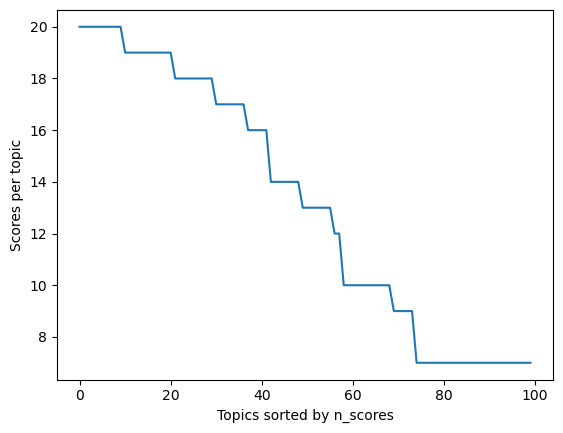

In [63]:
a = scores.groupby("sim_topic_id").agg({"trial_id":"count"}).sort_values("trial_id", ascending=False)
plt.plot(np.array(a["trial_id"]))
plt.xlabel("Topics sorted by n_scores")
plt.ylabel("Scores per topic")
plt.show()

In [54]:
# Number of scores per rater
scores.groupby("sim_rater_id").agg({"trial_id":"count"}).sort_values("trial_id", ascending=False)

,trial_id
sim_rater_id,
0,40
17,40
31,40
30,40
29,40
28,40
27,40
26,40
25,40
